# 
- **Full Name** : Fatemeh Karimi Barikarasfi
- **Student Code** : 610301060


Use CNN pretrained models for Parkinson’s Disease detection using DaTscan images. Dataset is collected from [PPMI](https://www.ppmi-info.org/).

In [5]:
!pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Importing Needed Libraries

In [7]:
import warnings

import os
import glob
import math
import cv2 as cv2
import numpy as np
import pandas as pd
import pydicom as dcm
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

warnings.filterwarnings("ignore", category=UserWarning)

## Loading and Spiliting Data

In [24]:
def generator(subset=0):
    df = pd.read_csv("./drive/MyDrive/final_6_22_2023.csv")

    df = pd.concat([
        df[(df["Group"] == "PD") & (df["Sex"] == "M")].sort_values("Acq Date", ascending=False).head(216),
        df[(df["Group"] == "PD") & (df["Sex"] == "F")].sort_values("Acq Date", ascending=False).head(216),
        df[(df["Group"] == "Control") & (df["Sex"] == "M")].sort_values("Acq Date", ascending=False).head(106),
        df[(df["Group"] == "Control") & (df["Sex"] == "F")].sort_values("Acq Date", ascending=False).head(106)
    ])

    if subset == 0:
        df = pd.concat([
            df[(df["Group"] == "PD") & (df["Sex"] == "M")].head(math.floor(216 * 0.8)),
            df[(df["Group"] == "PD") & (df["Sex"] == "F")].head(math.floor(216 * 0.8)),
            df[(df["Group"] == "Control") & (df["Sex"] == "M")].head(math.floor(106 * 0.8)),
            df[(df["Group"] == "Control") & (df["Sex"] == "F")].head(math.floor(106 * 0.8))
        ])

    if subset == 1:
        df = pd.concat([
            df[(df["Group"] == "PD") & (df["Sex"] == "M")].tail(math.ceil(216 * 0.2)),
            df[(df["Group"] == "PD") & (df["Sex"] == "F")].tail(math.ceil(216 * 0.2)),
            df[(df["Group"] == "Control") & (df["Sex"] == "M")].tail(math.ceil(106 * 0.2)),
            df[(df["Group"] == "Control") & (df["Sex"] == "F")].tail(math.ceil(106 * 0.2))
        ])

    for index, record in df.iterrows():
        label = record["Group"]
        subject = record["Subject"]
        dataId = record["Image Data ID"]
        file = dcm.dcmread(glob.glob(f"./drive/MyDrive/PPMI/{subject}/Reconstructed_DaTSCAN/*/{dataId}/*.dcm")[0])

        image = file.pixel_array[41]
        image = ((image - np.min(image)) / (np.max(image) - np.min(image)) * 255).astype(np.uint8)
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        image = cv2.resize(image, (224 , 224))

        yield (
            tf.convert_to_tensor(image),
            tf.constant([1, 0] if label == "Control" else [0, 1])
        )

trainset = tf.data.Dataset.from_generator(generator, args=(0,), output_signature=(
    tf.TensorSpec(shape=(224, 224, 3), dtype=tf.uint8),
    tf.TensorSpec(shape=(2), dtype=tf.uint8))
).shuffle(buffer_size=100, seed=310).batch(100)

testset = tf.data.Dataset.from_generator(generator, args=(1,), output_signature=(
    tf.TensorSpec(shape=(224, 224, 3), dtype=tf.uint8),
    tf.TensorSpec(shape=(2), dtype=tf.uint8))
).batch(1)

## Models

### VGG16

In [86]:
vgg16_model = tf.keras.applications.vgg16.VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

for layer in vgg16_model.layers:
    layer.trainable = False

input = tf.keras.layers.Input(shape=(224, 224, 3))

fusion = tf.keras.layers.Concatenate()([
     tf.keras.layers.GlobalAveragePooling2D()(vgg16_model(input)),

])
x = tf.keras.layers.Flatten()(fusion)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)

output = tf.keras.layers.Dense(2, activation="softmax")(x)

VGGmodel = tf.keras.models.Model(inputs=input, outputs=output)

VGGmodel.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [87]:
hist = VGGmodel.fit(trainset, validation_data=testset, epochs = 50)

Epoch 1/50


      6/Unknown - 10s 1s/step - loss: 2.7613 - accuracy: 0.4434

6/6 [==============================] - 12s 1s/step - loss: 2.7613 - accuracy: 0.4434 - val_loss: 0.7504 - val_accuracy: 0.6667
Epoch 2/50


6/6 [==============================] - ETA: 0s - loss: 1.7960 - accuracy: 0.5879

6/6 [==============================] - 11s 2s/step - loss: 1.7960 - accuracy: 0.5879 - val_loss: 0.8434 - val_accuracy: 0.6667
Epoch 3/50


6/6 [==============================] - ETA: 0s - loss: 1.5404 - accuracy: 0.6152

6/6 [==============================] - 11s 2s/step - loss: 1.5404 - accuracy: 0.6152 - val_loss: 0.6922 - val_accuracy: 0.6591
Epoch 4/50


6/6 [==============================] - ETA: 0s - loss: 1.4764 - accuracy: 0.6230

6/6 [==============================] - 11s 2s/step - loss: 1.4764 - accuracy: 0.6230 - val_loss: 0.5388 - val_accuracy: 0.6591
Epoch 5/50


6/6 [==============================] - ETA: 0s - loss: 1.1681 - accuracy: 0.6797

6/6 [==============================] - 11s 2s/step - loss: 1.1681 - accuracy: 0.6797 - val_loss: 0.4035 - val_accuracy: 0.7576
Epoch 6/50


6/6 [==============================] - ETA: 0s - loss: 1.0837 - accuracy: 0.6523

6/6 [==============================] - 10s 1s/step - loss: 1.0837 - accuracy: 0.6523 - val_loss: 0.3417 - val_accuracy: 0.8333
Epoch 7/50


6/6 [==============================] - ETA: 0s - loss: 1.0270 - accuracy: 0.6523

6/6 [==============================] - 11s 2s/step - loss: 1.0270 - accuracy: 0.6523 - val_loss: 0.3126 - val_accuracy: 0.8561
Epoch 8/50


6/6 [==============================] - ETA: 0s - loss: 0.9121 - accuracy: 0.6660

6/6 [==============================] - 11s 2s/step - loss: 0.9121 - accuracy: 0.6660 - val_loss: 0.3039 - val_accuracy: 0.8712
Epoch 9/50


6/6 [==============================] - ETA: 0s - loss: 0.8941 - accuracy: 0.6816

6/6 [==============================] - 13s 2s/step - loss: 0.8941 - accuracy: 0.6816 - val_loss: 0.2923 - val_accuracy: 0.8864
Epoch 10/50


6/6 [==============================] - ETA: 0s - loss: 0.8221 - accuracy: 0.6738

6/6 [==============================] - 13s 2s/step - loss: 0.8221 - accuracy: 0.6738 - val_loss: 0.2748 - val_accuracy: 0.9242
Epoch 11/50


6/6 [==============================] - ETA: 0s - loss: 0.7784 - accuracy: 0.7129

6/6 [==============================] - 14s 2s/step - loss: 0.7784 - accuracy: 0.7129 - val_loss: 0.2629 - val_accuracy: 0.9470
Epoch 12/50


6/6 [==============================] - ETA: 0s - loss: 0.6751 - accuracy: 0.7461

6/6 [==============================] - 15s 2s/step - loss: 0.6751 - accuracy: 0.7461 - val_loss: 0.2566 - val_accuracy: 0.9470
Epoch 13/50


6/6 [==============================] - ETA: 0s - loss: 0.7057 - accuracy: 0.7402

6/6 [==============================] - 15s 2s/step - loss: 0.7057 - accuracy: 0.7402 - val_loss: 0.2509 - val_accuracy: 0.9470
Epoch 14/50


6/6 [==============================] - ETA: 0s - loss: 0.7271 - accuracy: 0.7285

6/6 [==============================] - 12s 2s/step - loss: 0.7271 - accuracy: 0.7285 - val_loss: 0.2459 - val_accuracy: 0.9394
Epoch 15/50


6/6 [==============================] - ETA: 0s - loss: 0.6371 - accuracy: 0.7461

6/6 [==============================] - 11s 1s/step - loss: 0.6371 - accuracy: 0.7461 - val_loss: 0.2405 - val_accuracy: 0.9394
Epoch 16/50


6/6 [==============================] - ETA: 0s - loss: 0.6298 - accuracy: 0.7480

6/6 [==============================] - 15s 2s/step - loss: 0.6298 - accuracy: 0.7480 - val_loss: 0.2387 - val_accuracy: 0.9470
Epoch 17/50


6/6 [==============================] - ETA: 0s - loss: 0.5557 - accuracy: 0.7656

6/6 [==============================] - 14s 2s/step - loss: 0.5557 - accuracy: 0.7656 - val_loss: 0.2393 - val_accuracy: 0.9470
Epoch 18/50


6/6 [==============================] - ETA: 0s - loss: 0.5696 - accuracy: 0.7734

6/6 [==============================] - 11s 2s/step - loss: 0.5696 - accuracy: 0.7734 - val_loss: 0.2388 - val_accuracy: 0.9470
Epoch 19/50


6/6 [==============================] - ETA: 0s - loss: 0.5498 - accuracy: 0.7832

6/6 [==============================] - 11s 2s/step - loss: 0.5498 - accuracy: 0.7832 - val_loss: 0.2380 - val_accuracy: 0.9470
Epoch 20/50


6/6 [==============================] - ETA: 0s - loss: 0.5474 - accuracy: 0.7695

6/6 [==============================] - 13s 2s/step - loss: 0.5474 - accuracy: 0.7695 - val_loss: 0.2379 - val_accuracy: 0.9470
Epoch 21/50


6/6 [==============================] - ETA: 0s - loss: 0.5095 - accuracy: 0.7676

6/6 [==============================] - 13s 2s/step - loss: 0.5095 - accuracy: 0.7676 - val_loss: 0.2365 - val_accuracy: 0.9318
Epoch 22/50


6/6 [==============================] - ETA: 0s - loss: 0.4747 - accuracy: 0.7852

6/6 [==============================] - 11s 2s/step - loss: 0.4747 - accuracy: 0.7852 - val_loss: 0.2341 - val_accuracy: 0.9394
Epoch 23/50


6/6 [==============================] - ETA: 0s - loss: 0.4863 - accuracy: 0.7949

6/6 [==============================] - 11s 2s/step - loss: 0.4863 - accuracy: 0.7949 - val_loss: 0.2295 - val_accuracy: 0.9394
Epoch 24/50


6/6 [==============================] - ETA: 0s - loss: 0.4463 - accuracy: 0.8086

6/6 [==============================] - 11s 2s/step - loss: 0.4463 - accuracy: 0.8086 - val_loss: 0.2283 - val_accuracy: 0.9394
Epoch 25/50


6/6 [==============================] - ETA: 0s - loss: 0.3969 - accuracy: 0.8281

6/6 [==============================] - 11s 2s/step - loss: 0.3969 - accuracy: 0.8281 - val_loss: 0.2268 - val_accuracy: 0.9394
Epoch 26/50


6/6 [==============================] - ETA: 0s - loss: 0.4023 - accuracy: 0.8535

6/6 [==============================] - 10s 1s/step - loss: 0.4023 - accuracy: 0.8535 - val_loss: 0.2237 - val_accuracy: 0.9394
Epoch 27/50


6/6 [==============================] - ETA: 0s - loss: 0.4706 - accuracy: 0.7988

6/6 [==============================] - 11s 2s/step - loss: 0.4706 - accuracy: 0.7988 - val_loss: 0.2205 - val_accuracy: 0.9394
Epoch 28/50


6/6 [==============================] - ETA: 0s - loss: 0.4470 - accuracy: 0.8320

6/6 [==============================] - 11s 2s/step - loss: 0.4470 - accuracy: 0.8320 - val_loss: 0.2187 - val_accuracy: 0.9470
Epoch 29/50


6/6 [==============================] - ETA: 0s - loss: 0.4656 - accuracy: 0.8262

6/6 [==============================] - 11s 2s/step - loss: 0.4656 - accuracy: 0.8262 - val_loss: 0.2162 - val_accuracy: 0.9470
Epoch 30/50


6/6 [==============================] - ETA: 0s - loss: 0.4243 - accuracy: 0.8359

6/6 [==============================] - 11s 2s/step - loss: 0.4243 - accuracy: 0.8359 - val_loss: 0.2180 - val_accuracy: 0.9394
Epoch 31/50


6/6 [==============================] - ETA: 0s - loss: 0.3848 - accuracy: 0.8418

6/6 [==============================] - 11s 2s/step - loss: 0.3848 - accuracy: 0.8418 - val_loss: 0.2226 - val_accuracy: 0.9470
Epoch 32/50


6/6 [==============================] - ETA: 0s - loss: 0.3813 - accuracy: 0.8496

6/6 [==============================] - 11s 2s/step - loss: 0.3813 - accuracy: 0.8496 - val_loss: 0.2252 - val_accuracy: 0.9470
Epoch 33/50


6/6 [==============================] - ETA: 0s - loss: 0.3472 - accuracy: 0.8496

6/6 [==============================] - 11s 2s/step - loss: 0.3472 - accuracy: 0.8496 - val_loss: 0.2235 - val_accuracy: 0.9318
Epoch 34/50


6/6 [==============================] - ETA: 0s - loss: 0.3734 - accuracy: 0.8262

6/6 [==============================] - 11s 2s/step - loss: 0.3734 - accuracy: 0.8262 - val_loss: 0.2183 - val_accuracy: 0.9394
Epoch 35/50


6/6 [==============================] - ETA: 0s - loss: 0.3387 - accuracy: 0.8535

6/6 [==============================] - 10s 1s/step - loss: 0.3387 - accuracy: 0.8535 - val_loss: 0.2150 - val_accuracy: 0.9394
Epoch 36/50


6/6 [==============================] - ETA: 0s - loss: 0.3429 - accuracy: 0.8535

6/6 [==============================] - 12s 2s/step - loss: 0.3429 - accuracy: 0.8535 - val_loss: 0.2142 - val_accuracy: 0.9394
Epoch 37/50


6/6 [==============================] - ETA: 0s - loss: 0.3500 - accuracy: 0.8594

6/6 [==============================] - 13s 2s/step - loss: 0.3500 - accuracy: 0.8594 - val_loss: 0.2156 - val_accuracy: 0.9394
Epoch 38/50


6/6 [==============================] - ETA: 0s - loss: 0.3512 - accuracy: 0.8496

6/6 [==============================] - 11s 1s/step - loss: 0.3512 - accuracy: 0.8496 - val_loss: 0.2138 - val_accuracy: 0.9394
Epoch 39/50


6/6 [==============================] - ETA: 0s - loss: 0.3473 - accuracy: 0.8594

6/6 [==============================] - 11s 2s/step - loss: 0.3473 - accuracy: 0.8594 - val_loss: 0.2122 - val_accuracy: 0.9394
Epoch 40/50


6/6 [==============================] - ETA: 0s - loss: 0.3487 - accuracy: 0.8691

6/6 [==============================] - 11s 2s/step - loss: 0.3487 - accuracy: 0.8691 - val_loss: 0.2124 - val_accuracy: 0.9394
Epoch 41/50


6/6 [==============================] - ETA: 0s - loss: 0.3315 - accuracy: 0.8750

6/6 [==============================] - 11s 2s/step - loss: 0.3315 - accuracy: 0.8750 - val_loss: 0.2093 - val_accuracy: 0.9394
Epoch 42/50


6/6 [==============================] - ETA: 0s - loss: 0.3065 - accuracy: 0.8770

6/6 [==============================] - 11s 2s/step - loss: 0.3065 - accuracy: 0.8770 - val_loss: 0.2035 - val_accuracy: 0.9394
Epoch 43/50


6/6 [==============================] - ETA: 0s - loss: 0.3049 - accuracy: 0.8711

6/6 [==============================] - 11s 2s/step - loss: 0.3049 - accuracy: 0.8711 - val_loss: 0.1980 - val_accuracy: 0.9394
Epoch 44/50


6/6 [==============================] - ETA: 0s - loss: 0.3080 - accuracy: 0.8828

6/6 [==============================] - 11s 2s/step - loss: 0.3080 - accuracy: 0.8828 - val_loss: 0.1960 - val_accuracy: 0.9394
Epoch 45/50


6/6 [==============================] - ETA: 0s - loss: 0.2866 - accuracy: 0.8867

6/6 [==============================] - 10s 1s/step - loss: 0.2866 - accuracy: 0.8867 - val_loss: 0.1943 - val_accuracy: 0.9394
Epoch 46/50


6/6 [==============================] - ETA: 0s - loss: 0.3313 - accuracy: 0.8535

6/6 [==============================] - 11s 2s/step - loss: 0.3313 - accuracy: 0.8535 - val_loss: 0.1927 - val_accuracy: 0.9394
Epoch 47/50


6/6 [==============================] - ETA: 0s - loss: 0.2450 - accuracy: 0.9121

6/6 [==============================] - 11s 2s/step - loss: 0.2450 - accuracy: 0.9121 - val_loss: 0.1908 - val_accuracy: 0.9394
Epoch 48/50


6/6 [==============================] - ETA: 0s - loss: 0.2660 - accuracy: 0.8887

6/6 [==============================] - 11s 2s/step - loss: 0.2660 - accuracy: 0.8887 - val_loss: 0.1885 - val_accuracy: 0.9394
Epoch 49/50


6/6 [==============================] - ETA: 0s - loss: 0.2815 - accuracy: 0.8848

6/6 [==============================] - 11s 2s/step - loss: 0.2815 - accuracy: 0.8848 - val_loss: 0.1878 - val_accuracy: 0.9394
Epoch 50/50


6/6 [==============================] - ETA: 0s - loss: 0.2618 - accuracy: 0.8984

6/6 [==============================] - 11s 2s/step - loss: 0.2618 - accuracy: 0.8984 - val_loss: 0.1866 - val_accuracy: 0.9394


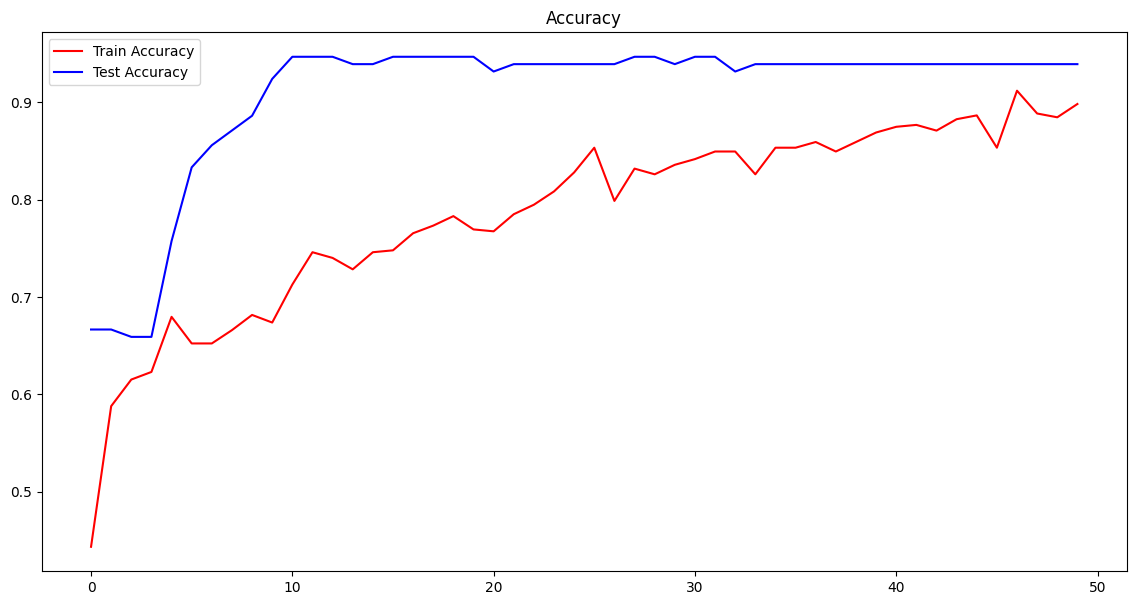

In [88]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

epochs = range(len(acc))
plt.figure(figsize = (14, 7))
plt.title('Accuracy')
plt.plot(epochs, acc, 'r', label = 'Train Accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Test Accuracy')
plt.legend(loc = 'upper left')

plt.show()

In [89]:
print(VGGmodel.evaluate(testset))

     10/Unknown - 0s 19ms/step - loss: 0.1337 - accuracy: 1.0000

132/132 [==============================] - 2s 18ms/step - loss: 0.1866 - accuracy: 0.9394
[0.18659339845180511, 0.939393937587738]


In [90]:
testds = list(testset)

y_true = [y.numpy().argmax(1)[0] for _, y in testds]
y_pred1 = VGGmodel.predict(tf.stack([x[0] for x, _ in testds])).argmax(1)

tf.math.confusion_matrix(labels=y_true, predictions=y_pred1)

5/5 [==============================] - 1s 134ms/step


<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[40,  4],
       [ 4, 84]], dtype=int32)>

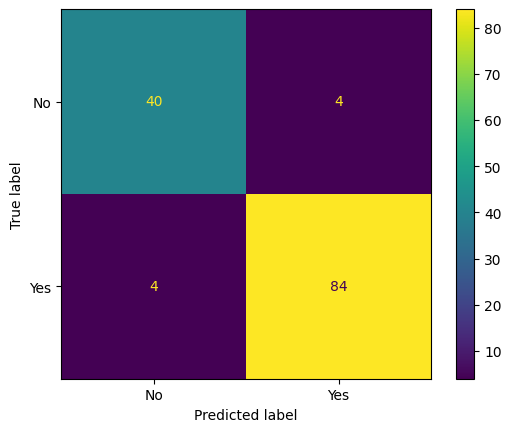

In [91]:
ConfusionMatrixDisplay(confusion_matrix(y_pred1, y_true), display_labels = ['No', 'Yes'], ).plot()
plt.show()

In [92]:
print(classification_report(y_pred1, y_true))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91        44
           1       0.95      0.95      0.95        88

    accuracy                           0.94       132
   macro avg       0.93      0.93      0.93       132
weighted avg       0.94      0.94      0.94       132



### ResNet50


In [93]:
resnet50_model = tf.keras.applications.resnet50.ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

for layer in resnet50_model.layers:
    layer.trainable = False

input = tf.keras.layers.Input(shape=(224, 224, 3))

fusion = tf.keras.layers.Concatenate()([
     tf.keras.layers.GlobalAveragePooling2D()(resnet50_model(input)),
])
x = tf.keras.layers.Flatten()(fusion)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)

output = tf.keras.layers.Dense(2, activation="softmax")(x)

ResNetmodel = tf.keras.models.Model(inputs=input, outputs=output)

ResNetmodel.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [94]:
hist = ResNetmodel.fit(trainset, validation_data=testset, epochs = 50)

Epoch 1/50


      5/Unknown - 12s 1s/step - loss: 2.1287 - accuracy: 0.6460

6/6 [==============================] - 15s 2s/step - loss: 2.1504 - accuracy: 0.6387 - val_loss: 1.0427 - val_accuracy: 0.6667
Epoch 2/50


5/6 [========================>.....] - ETA: 1s - loss: 1.0090 - accuracy: 0.6660

6/6 [==============================] - 10s 1s/step - loss: 0.9990 - accuracy: 0.6680 - val_loss: 0.7146 - val_accuracy: 0.4924
Epoch 3/50


5/6 [========================>.....] - ETA: 1s - loss: 0.9651 - accuracy: 0.5680

6/6 [==============================] - 11s 2s/step - loss: 0.9614 - accuracy: 0.5684 - val_loss: 0.9775 - val_accuracy: 0.3939
Epoch 4/50


5/6 [========================>.....] - ETA: 1s - loss: 1.0733 - accuracy: 0.5140

6/6 [==============================] - 11s 2s/step - loss: 1.0672 - accuracy: 0.5156 - val_loss: 0.6939 - val_accuracy: 0.5000
Epoch 5/50


5/6 [========================>.....] - ETA: 1s - loss: 0.9167 - accuracy: 0.5800

6/6 [==============================] - 9s 1s/step - loss: 0.9223 - accuracy: 0.5801 - val_loss: 0.4872 - val_accuracy: 0.7955
Epoch 6/50


5/6 [========================>.....] - ETA: 1s - loss: 0.7251 - accuracy: 0.6840

6/6 [==============================] - 10s 1s/step - loss: 0.7223 - accuracy: 0.6836 - val_loss: 0.4715 - val_accuracy: 0.8030
Epoch 7/50


5/6 [========================>.....] - ETA: 1s - loss: 0.6535 - accuracy: 0.6800

6/6 [==============================] - 10s 2s/step - loss: 0.6633 - accuracy: 0.6777 - val_loss: 0.4784 - val_accuracy: 0.8030
Epoch 8/50


5/6 [========================>.....] - ETA: 1s - loss: 0.6091 - accuracy: 0.6680

6/6 [==============================] - 12s 2s/step - loss: 0.6109 - accuracy: 0.6641 - val_loss: 0.5098 - val_accuracy: 0.7424
Epoch 9/50


5/6 [========================>.....] - ETA: 1s - loss: 0.6188 - accuracy: 0.6740

6/6 [==============================] - 10s 1s/step - loss: 0.6216 - accuracy: 0.6738 - val_loss: 0.4808 - val_accuracy: 0.7803
Epoch 10/50


5/6 [========================>.....] - ETA: 1s - loss: 0.6060 - accuracy: 0.6940

6/6 [==============================] - 10s 1s/step - loss: 0.6087 - accuracy: 0.6914 - val_loss: 0.4541 - val_accuracy: 0.8182
Epoch 11/50


5/6 [========================>.....] - ETA: 1s - loss: 0.5345 - accuracy: 0.7380

6/6 [==============================] - 13s 2s/step - loss: 0.5313 - accuracy: 0.7422 - val_loss: 0.4388 - val_accuracy: 0.8182
Epoch 12/50


5/6 [========================>.....] - ETA: 1s - loss: 0.5645 - accuracy: 0.7260

6/6 [==============================] - 13s 2s/step - loss: 0.5795 - accuracy: 0.7246 - val_loss: 0.4172 - val_accuracy: 0.8409
Epoch 13/50


5/6 [========================>.....] - ETA: 1s - loss: 0.5196 - accuracy: 0.7300

6/6 [==============================] - 11s 2s/step - loss: 0.5232 - accuracy: 0.7285 - val_loss: 0.4306 - val_accuracy: 0.8258
Epoch 14/50


5/6 [========================>.....] - ETA: 1s - loss: 0.4773 - accuracy: 0.7760

6/6 [==============================] - 10s 1s/step - loss: 0.4858 - accuracy: 0.7734 - val_loss: 0.4198 - val_accuracy: 0.8333
Epoch 15/50


5/6 [========================>.....] - ETA: 1s - loss: 0.4907 - accuracy: 0.7500

6/6 [==============================] - 10s 1s/step - loss: 0.4898 - accuracy: 0.7500 - val_loss: 0.4087 - val_accuracy: 0.8485
Epoch 16/50


5/6 [========================>.....] - ETA: 1s - loss: 0.4665 - accuracy: 0.7840

6/6 [==============================] - 10s 2s/step - loss: 0.4612 - accuracy: 0.7871 - val_loss: 0.3789 - val_accuracy: 0.8485
Epoch 17/50


5/6 [========================>.....] - ETA: 1s - loss: 0.4897 - accuracy: 0.7620

6/6 [==============================] - 12s 2s/step - loss: 0.4892 - accuracy: 0.7598 - val_loss: 0.3523 - val_accuracy: 0.8485
Epoch 18/50


5/6 [========================>.....] - ETA: 1s - loss: 0.4521 - accuracy: 0.7780

6/6 [==============================] - 10s 1s/step - loss: 0.4510 - accuracy: 0.7793 - val_loss: 0.3426 - val_accuracy: 0.8636
Epoch 19/50


5/6 [========================>.....] - ETA: 1s - loss: 0.4141 - accuracy: 0.8140

6/6 [==============================] - 10s 1s/step - loss: 0.4181 - accuracy: 0.8086 - val_loss: 0.3366 - val_accuracy: 0.8712
Epoch 20/50


5/6 [========================>.....] - ETA: 1s - loss: 0.4101 - accuracy: 0.8120

6/6 [==============================] - 13s 2s/step - loss: 0.4168 - accuracy: 0.8066 - val_loss: 0.3482 - val_accuracy: 0.8561
Epoch 21/50


5/6 [========================>.....] - ETA: 1s - loss: 0.4373 - accuracy: 0.8020

6/6 [==============================] - 13s 2s/step - loss: 0.4389 - accuracy: 0.8008 - val_loss: 0.3304 - val_accuracy: 0.8788
Epoch 22/50


5/6 [========================>.....] - ETA: 1s - loss: 0.4128 - accuracy: 0.8180

6/6 [==============================] - 12s 2s/step - loss: 0.4123 - accuracy: 0.8164 - val_loss: 0.3158 - val_accuracy: 0.8712
Epoch 23/50


5/6 [========================>.....] - ETA: 1s - loss: 0.3895 - accuracy: 0.8240

6/6 [==============================] - 12s 2s/step - loss: 0.3940 - accuracy: 0.8223 - val_loss: 0.3106 - val_accuracy: 0.8788
Epoch 24/50


5/6 [========================>.....] - ETA: 1s - loss: 0.3454 - accuracy: 0.8460

6/6 [==============================] - 11s 2s/step - loss: 0.3403 - accuracy: 0.8496 - val_loss: 0.3038 - val_accuracy: 0.8788
Epoch 25/50


5/6 [========================>.....] - ETA: 1s - loss: 0.3720 - accuracy: 0.8340

6/6 [==============================] - 13s 2s/step - loss: 0.3733 - accuracy: 0.8340 - val_loss: 0.2793 - val_accuracy: 0.8864
Epoch 26/50


5/6 [========================>.....] - ETA: 1s - loss: 0.3481 - accuracy: 0.8540

6/6 [==============================] - 10s 2s/step - loss: 0.3500 - accuracy: 0.8535 - val_loss: 0.2722 - val_accuracy: 0.8939
Epoch 27/50


5/6 [========================>.....] - ETA: 1s - loss: 0.3093 - accuracy: 0.8800

6/6 [==============================] - 10s 1s/step - loss: 0.3143 - accuracy: 0.8789 - val_loss: 0.2845 - val_accuracy: 0.8864
Epoch 28/50


5/6 [========================>.....] - ETA: 1s - loss: 0.3340 - accuracy: 0.8620

6/6 [==============================] - 10s 1s/step - loss: 0.3395 - accuracy: 0.8574 - val_loss: 0.2818 - val_accuracy: 0.8788
Epoch 29/50


5/6 [========================>.....] - ETA: 1s - loss: 0.3396 - accuracy: 0.8500

6/6 [==============================] - 13s 2s/step - loss: 0.3425 - accuracy: 0.8496 - val_loss: 0.2730 - val_accuracy: 0.8864
Epoch 30/50


5/6 [========================>.....] - ETA: 1s - loss: 0.2950 - accuracy: 0.8900

6/6 [==============================] - 11s 2s/step - loss: 0.2930 - accuracy: 0.8906 - val_loss: 0.2546 - val_accuracy: 0.9091
Epoch 31/50


5/6 [========================>.....] - ETA: 1s - loss: 0.2859 - accuracy: 0.8840

6/6 [==============================] - 9s 1s/step - loss: 0.2847 - accuracy: 0.8848 - val_loss: 0.2341 - val_accuracy: 0.9167
Epoch 32/50


5/6 [========================>.....] - ETA: 1s - loss: 0.2798 - accuracy: 0.8940

6/6 [==============================] - 10s 1s/step - loss: 0.2914 - accuracy: 0.8887 - val_loss: 0.2354 - val_accuracy: 0.9167
Epoch 33/50


5/6 [========================>.....] - ETA: 1s - loss: 0.3057 - accuracy: 0.8800

6/6 [==============================] - 10s 2s/step - loss: 0.3037 - accuracy: 0.8809 - val_loss: 0.2414 - val_accuracy: 0.8939
Epoch 34/50


5/6 [========================>.....] - ETA: 1s - loss: 0.2892 - accuracy: 0.8960

6/6 [==============================] - 9s 1s/step - loss: 0.2905 - accuracy: 0.8926 - val_loss: 0.2374 - val_accuracy: 0.8939
Epoch 35/50


5/6 [========================>.....] - ETA: 1s - loss: 0.2606 - accuracy: 0.8940

6/6 [==============================] - 10s 1s/step - loss: 0.2580 - accuracy: 0.8945 - val_loss: 0.2217 - val_accuracy: 0.9167
Epoch 36/50


5/6 [========================>.....] - ETA: 1s - loss: 0.2465 - accuracy: 0.8960

6/6 [==============================] - 10s 2s/step - loss: 0.2531 - accuracy: 0.8926 - val_loss: 0.2040 - val_accuracy: 0.9167
Epoch 37/50


5/6 [========================>.....] - ETA: 1s - loss: 0.2077 - accuracy: 0.9280

6/6 [==============================] - 11s 2s/step - loss: 0.2221 - accuracy: 0.9219 - val_loss: 0.2038 - val_accuracy: 0.9167
Epoch 38/50


5/6 [========================>.....] - ETA: 1s - loss: 0.2345 - accuracy: 0.8980

6/6 [==============================] - 10s 1s/step - loss: 0.2365 - accuracy: 0.8965 - val_loss: 0.2067 - val_accuracy: 0.9167
Epoch 39/50


5/6 [========================>.....] - ETA: 1s - loss: 0.2426 - accuracy: 0.9080

6/6 [==============================] - 10s 1s/step - loss: 0.2405 - accuracy: 0.9102 - val_loss: 0.1966 - val_accuracy: 0.9167
Epoch 40/50


6/6 [==============================] - ETA: 0s - loss: 0.2457 - accuracy: 0.9082

6/6 [==============================] - 10s 2s/step - loss: 0.2457 - accuracy: 0.9082 - val_loss: 0.1945 - val_accuracy: 0.9167
Epoch 41/50


5/6 [========================>.....] - ETA: 1s - loss: 0.2346 - accuracy: 0.9260

6/6 [==============================] - 12s 2s/step - loss: 0.2338 - accuracy: 0.9258 - val_loss: 0.1914 - val_accuracy: 0.9167
Epoch 42/50


5/6 [========================>.....] - ETA: 1s - loss: 0.2430 - accuracy: 0.9040

6/6 [==============================] - 10s 1s/step - loss: 0.2425 - accuracy: 0.9043 - val_loss: 0.1847 - val_accuracy: 0.9167
Epoch 43/50


5/6 [========================>.....] - ETA: 1s - loss: 0.2143 - accuracy: 0.9200

6/6 [==============================] - 10s 1s/step - loss: 0.2137 - accuracy: 0.9199 - val_loss: 0.1926 - val_accuracy: 0.9167
Epoch 44/50


5/6 [========================>.....] - ETA: 1s - loss: 0.2470 - accuracy: 0.8900

6/6 [==============================] - 11s 2s/step - loss: 0.2488 - accuracy: 0.8887 - val_loss: 0.1950 - val_accuracy: 0.9091
Epoch 45/50


5/6 [========================>.....] - ETA: 1s - loss: 0.2371 - accuracy: 0.9000

6/6 [==============================] - 11s 2s/step - loss: 0.2331 - accuracy: 0.9023 - val_loss: 0.1841 - val_accuracy: 0.9167
Epoch 46/50


5/6 [========================>.....] - ETA: 1s - loss: 0.2184 - accuracy: 0.9260

6/6 [==============================] - 10s 1s/step - loss: 0.2185 - accuracy: 0.9258 - val_loss: 0.1728 - val_accuracy: 0.9167
Epoch 47/50


5/6 [========================>.....] - ETA: 1s - loss: 0.2170 - accuracy: 0.9200

6/6 [==============================] - 10s 2s/step - loss: 0.2189 - accuracy: 0.9160 - val_loss: 0.1765 - val_accuracy: 0.9167
Epoch 48/50


5/6 [========================>.....] - ETA: 1s - loss: 0.2151 - accuracy: 0.9220

6/6 [==============================] - 13s 2s/step - loss: 0.2111 - accuracy: 0.9238 - val_loss: 0.1936 - val_accuracy: 0.9091
Epoch 49/50


5/6 [========================>.....] - ETA: 1s - loss: 0.1917 - accuracy: 0.9380

6/6 [==============================] - 11s 2s/step - loss: 0.1892 - accuracy: 0.9395 - val_loss: 0.1825 - val_accuracy: 0.9167
Epoch 50/50


5/6 [========================>.....] - ETA: 1s - loss: 0.1994 - accuracy: 0.9180

6/6 [==============================] - 10s 1s/step - loss: 0.1987 - accuracy: 0.9199 - val_loss: 0.1661 - val_accuracy: 0.9167


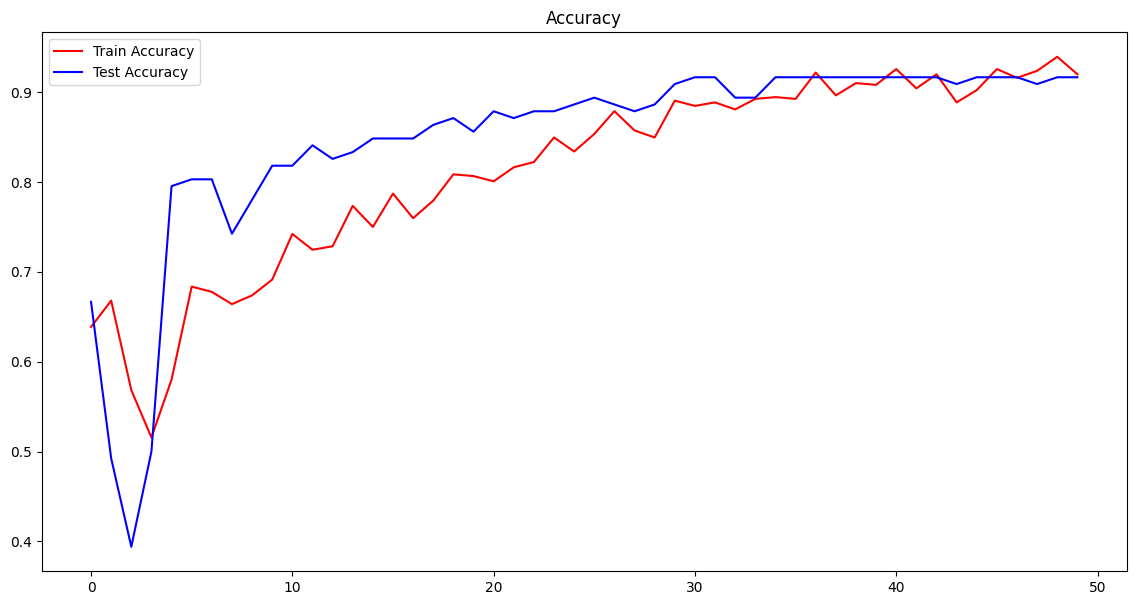

In [95]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

epochs = range(len(acc))
plt.figure(figsize = (14, 7))
plt.title('Accuracy')
plt.plot(epochs, acc, 'r', label = 'Train Accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Test Accuracy')
plt.legend(loc = 'upper left')

plt.show()

In [96]:
print(ResNetmodel.evaluate(testset))

     10/Unknown - 0s 19ms/step - loss: 0.1921 - accuracy: 0.9000

132/132 [==============================] - 3s 25ms/step - loss: 0.1661 - accuracy: 0.9167
[0.16611599922180176, 0.9166666865348816]


In [97]:
#testds = list(testset)

# y_true = [y.numpy().argmax(1)[0] for _, y in testds]
y_pred2 = ResNetmodel.predict(tf.stack([x[0] for x, _ in testds])).argmax(1)

tf.math.confusion_matrix(labels=y_true, predictions=y_pred2)

5/5 [==============================] - 1s 98ms/step


<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[41,  3],
       [ 8, 80]], dtype=int32)>

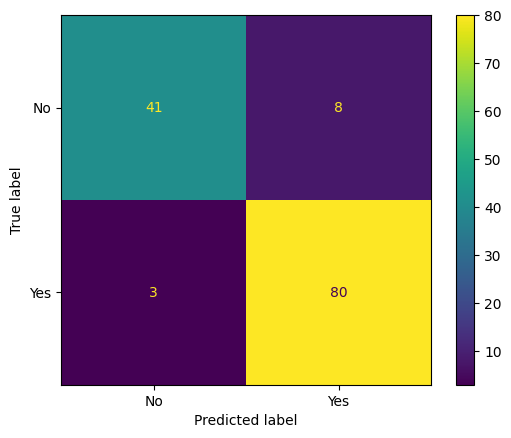

In [98]:
ConfusionMatrixDisplay(confusion_matrix(y_pred2, y_true), display_labels = ['No', 'Yes'], ).plot()
plt.show()

In [107]:
print(classification_report(y_pred2, y_true))

              precision    recall  f1-score   support

           0       0.93      0.84      0.88        49
           1       0.91      0.96      0.94        83

    accuracy                           0.92       132
   macro avg       0.92      0.90      0.91       132
weighted avg       0.92      0.92      0.92       132



#### Inception-V3

In [100]:
inceptionv3_model = tf.keras.applications.inception_v3.InceptionV3(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

for layer in inceptionv3_model.layers:
    layer.trainable = False

input = tf.keras.layers.Input(shape=(224, 224, 3))

fusion = tf.keras.layers.Concatenate()([
     tf.keras.layers.GlobalAveragePooling2D()(inceptionv3_model(input))
])
x = tf.keras.layers.Flatten()(fusion)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)

output = tf.keras.layers.Dense(2, activation="softmax")(x)

InceptionV3model = tf.keras.models.Model(inputs=input, outputs=output)

InceptionV3model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [101]:
hist = InceptionV3model.fit(trainset, validation_data=testset, epochs = 50)

Epoch 1/50


      5/Unknown - 13s 956ms/step - loss: 38.9978 - accuracy: 0.3360

6/6 [==============================] - 17s 2s/step - loss: 38.8063 - accuracy: 0.3359 - val_loss: 14.2512 - val_accuracy: 0.6667
Epoch 2/50


5/6 [========================>.....] - ETA: 2s - loss: 15.3827 - accuracy: 0.6120

6/6 [==============================] - 15s 2s/step - loss: 15.8437 - accuracy: 0.6074 - val_loss: 4.9220 - val_accuracy: 0.6742
Epoch 3/50


5/6 [========================>.....] - ETA: 1s - loss: 10.0722 - accuracy: 0.6700

6/6 [==============================] - 10s 2s/step - loss: 10.1566 - accuracy: 0.6680 - val_loss: 0.9977 - val_accuracy: 0.8788
Epoch 4/50


5/6 [========================>.....] - ETA: 1s - loss: 9.4475 - accuracy: 0.6460

6/6 [==============================] - 12s 2s/step - loss: 9.2777 - accuracy: 0.6504 - val_loss: 1.7175 - val_accuracy: 0.8409
Epoch 5/50


5/6 [========================>.....] - ETA: 1s - loss: 8.2269 - accuracy: 0.6860

6/6 [==============================] - 10s 2s/step - loss: 8.2079 - accuracy: 0.6797 - val_loss: 1.8140 - val_accuracy: 0.8409
Epoch 6/50


5/6 [========================>.....] - ETA: 1s - loss: 7.6254 - accuracy: 0.6600

6/6 [==============================] - 10s 1s/step - loss: 7.5689 - accuracy: 0.6582 - val_loss: 1.2810 - val_accuracy: 0.8712
Epoch 7/50


5/6 [========================>.....] - ETA: 1s - loss: 6.2890 - accuracy: 0.7260

6/6 [==============================] - 10s 2s/step - loss: 6.2905 - accuracy: 0.7266 - val_loss: 1.3774 - val_accuracy: 0.8712
Epoch 8/50


5/6 [========================>.....] - ETA: 1s - loss: 4.7549 - accuracy: 0.7680

6/6 [==============================] - 11s 2s/step - loss: 5.1143 - accuracy: 0.7656 - val_loss: 1.4998 - val_accuracy: 0.8636
Epoch 9/50


5/6 [========================>.....] - ETA: 1s - loss: 4.9530 - accuracy: 0.7360

6/6 [==============================] - 10s 1s/step - loss: 4.9530 - accuracy: 0.7383 - val_loss: 1.4857 - val_accuracy: 0.8636
Epoch 10/50


5/6 [========================>.....] - ETA: 1s - loss: 4.2979 - accuracy: 0.7500

6/6 [==============================] - 10s 1s/step - loss: 4.3539 - accuracy: 0.7480 - val_loss: 1.4195 - val_accuracy: 0.8636
Epoch 11/50


5/6 [========================>.....] - ETA: 1s - loss: 3.8215 - accuracy: 0.7800

6/6 [==============================] - 12s 2s/step - loss: 3.8836 - accuracy: 0.7773 - val_loss: 1.3925 - val_accuracy: 0.8636
Epoch 12/50


5/6 [========================>.....] - ETA: 1s - loss: 3.8352 - accuracy: 0.7700

6/6 [==============================] - 9s 1s/step - loss: 4.0295 - accuracy: 0.7656 - val_loss: 1.4540 - val_accuracy: 0.8561
Epoch 13/50


5/6 [========================>.....] - ETA: 1s - loss: 3.4444 - accuracy: 0.7820

6/6 [==============================] - 10s 1s/step - loss: 3.3907 - accuracy: 0.7812 - val_loss: 1.4863 - val_accuracy: 0.8485
Epoch 14/50


5/6 [========================>.....] - ETA: 1s - loss: 3.8754 - accuracy: 0.7820

6/6 [==============================] - 10s 1s/step - loss: 3.8101 - accuracy: 0.7832 - val_loss: 1.2105 - val_accuracy: 0.8636
Epoch 15/50


5/6 [========================>.....] - ETA: 1s - loss: 3.2542 - accuracy: 0.7720

6/6 [==============================] - 10s 2s/step - loss: 3.2786 - accuracy: 0.7695 - val_loss: 1.0049 - val_accuracy: 0.8788
Epoch 16/50


5/6 [========================>.....] - ETA: 1s - loss: 2.4144 - accuracy: 0.8340

6/6 [==============================] - 9s 1s/step - loss: 2.3751 - accuracy: 0.8340 - val_loss: 1.0328 - val_accuracy: 0.8788
Epoch 17/50


5/6 [========================>.....] - ETA: 1s - loss: 2.5294 - accuracy: 0.7980

6/6 [==============================] - 10s 1s/step - loss: 2.4791 - accuracy: 0.8008 - val_loss: 1.1671 - val_accuracy: 0.8636
Epoch 18/50


5/6 [========================>.....] - ETA: 1s - loss: 2.4945 - accuracy: 0.8180

6/6 [==============================] - 13s 2s/step - loss: 2.4669 - accuracy: 0.8164 - val_loss: 1.1687 - val_accuracy: 0.8712
Epoch 19/50


5/6 [========================>.....] - ETA: 1s - loss: 2.1355 - accuracy: 0.8420

6/6 [==============================] - 13s 2s/step - loss: 2.0859 - accuracy: 0.8457 - val_loss: 1.0922 - val_accuracy: 0.8864
Epoch 20/50


5/6 [========================>.....] - ETA: 1s - loss: 1.9966 - accuracy: 0.8400

6/6 [==============================] - 11s 1s/step - loss: 1.9811 - accuracy: 0.8418 - val_loss: 1.0030 - val_accuracy: 0.8864
Epoch 21/50


5/6 [========================>.....] - ETA: 1s - loss: 2.0842 - accuracy: 0.8460

6/6 [==============================] - 11s 2s/step - loss: 2.1271 - accuracy: 0.8438 - val_loss: 0.9473 - val_accuracy: 0.8864
Epoch 22/50


5/6 [========================>.....] - ETA: 1s - loss: 1.8167 - accuracy: 0.8440

6/6 [==============================] - 10s 1s/step - loss: 1.7742 - accuracy: 0.8477 - val_loss: 0.9645 - val_accuracy: 0.8712
Epoch 23/50


5/6 [========================>.....] - ETA: 1s - loss: 1.7007 - accuracy: 0.8460

6/6 [==============================] - 10s 1s/step - loss: 1.7077 - accuracy: 0.8457 - val_loss: 0.8915 - val_accuracy: 0.8712
Epoch 24/50


5/6 [========================>.....] - ETA: 1s - loss: 1.7976 - accuracy: 0.8400

6/6 [==============================] - 10s 2s/step - loss: 1.7555 - accuracy: 0.8438 - val_loss: 0.8249 - val_accuracy: 0.8712
Epoch 25/50


5/6 [========================>.....] - ETA: 1s - loss: 1.5965 - accuracy: 0.8640

6/6 [==============================] - 10s 1s/step - loss: 1.6366 - accuracy: 0.8574 - val_loss: 0.7310 - val_accuracy: 0.8712
Epoch 26/50


5/6 [========================>.....] - ETA: 1s - loss: 1.6625 - accuracy: 0.8420

6/6 [==============================] - 13s 2s/step - loss: 1.6344 - accuracy: 0.8438 - val_loss: 0.6220 - val_accuracy: 0.8864
Epoch 27/50


5/6 [========================>.....] - ETA: 1s - loss: 1.7039 - accuracy: 0.8220

6/6 [==============================] - 10s 2s/step - loss: 1.6945 - accuracy: 0.8203 - val_loss: 0.5371 - val_accuracy: 0.9015
Epoch 28/50


5/6 [========================>.....] - ETA: 1s - loss: 1.5071 - accuracy: 0.8740

6/6 [==============================] - 12s 2s/step - loss: 1.5681 - accuracy: 0.8672 - val_loss: 0.5730 - val_accuracy: 0.8939
Epoch 29/50


5/6 [========================>.....] - ETA: 1s - loss: 1.4103 - accuracy: 0.8640

6/6 [==============================] - 9s 1s/step - loss: 1.4913 - accuracy: 0.8555 - val_loss: 0.6383 - val_accuracy: 0.8864
Epoch 30/50


5/6 [========================>.....] - ETA: 1s - loss: 1.3627 - accuracy: 0.8680

6/6 [==============================] - 10s 1s/step - loss: 1.3470 - accuracy: 0.8672 - val_loss: 0.6826 - val_accuracy: 0.8636
Epoch 31/50


5/6 [========================>.....] - ETA: 1s - loss: 1.7779 - accuracy: 0.8220

6/6 [==============================] - 10s 2s/step - loss: 1.7378 - accuracy: 0.8242 - val_loss: 0.5945 - val_accuracy: 0.8864
Epoch 32/50


5/6 [========================>.....] - ETA: 1s - loss: 1.5525 - accuracy: 0.8440

6/6 [==============================] - 11s 2s/step - loss: 1.5331 - accuracy: 0.8438 - val_loss: 0.5494 - val_accuracy: 0.8939
Epoch 33/50


5/6 [========================>.....] - ETA: 1s - loss: 1.2519 - accuracy: 0.8600

6/6 [==============================] - 10s 1s/step - loss: 1.2759 - accuracy: 0.8594 - val_loss: 0.5421 - val_accuracy: 0.8864
Epoch 34/50


5/6 [========================>.....] - ETA: 1s - loss: 1.1757 - accuracy: 0.8800

6/6 [==============================] - 10s 2s/step - loss: 1.1966 - accuracy: 0.8770 - val_loss: 0.5193 - val_accuracy: 0.8788
Epoch 35/50


5/6 [========================>.....] - ETA: 1s - loss: 1.0631 - accuracy: 0.8440

6/6 [==============================] - 12s 2s/step - loss: 1.0580 - accuracy: 0.8438 - val_loss: 0.4798 - val_accuracy: 0.8788
Epoch 36/50


5/6 [========================>.....] - ETA: 1s - loss: 1.1670 - accuracy: 0.8560

6/6 [==============================] - 9s 1s/step - loss: 1.2136 - accuracy: 0.8555 - val_loss: 0.4318 - val_accuracy: 0.9015
Epoch 37/50


5/6 [========================>.....] - ETA: 1s - loss: 1.6049 - accuracy: 0.8380

6/6 [==============================] - 10s 1s/step - loss: 1.5756 - accuracy: 0.8379 - val_loss: 0.3483 - val_accuracy: 0.9167
Epoch 38/50


5/6 [========================>.....] - ETA: 1s - loss: 1.5279 - accuracy: 0.8340

6/6 [==============================] - 10s 2s/step - loss: 1.4923 - accuracy: 0.8379 - val_loss: 0.3244 - val_accuracy: 0.9167
Epoch 39/50


5/6 [========================>.....] - ETA: 1s - loss: 1.2168 - accuracy: 0.8560

6/6 [==============================] - 10s 2s/step - loss: 1.2306 - accuracy: 0.8535 - val_loss: 0.3534 - val_accuracy: 0.9091
Epoch 40/50


5/6 [========================>.....] - ETA: 1s - loss: 0.8709 - accuracy: 0.8920

6/6 [==============================] - 10s 1s/step - loss: 0.8614 - accuracy: 0.8906 - val_loss: 0.4408 - val_accuracy: 0.9015
Epoch 41/50


5/6 [========================>.....] - ETA: 1s - loss: 0.9664 - accuracy: 0.8660

6/6 [==============================] - 12s 2s/step - loss: 0.9650 - accuracy: 0.8652 - val_loss: 0.4553 - val_accuracy: 0.9015
Epoch 42/50


5/6 [========================>.....] - ETA: 1s - loss: 0.9679 - accuracy: 0.8580

6/6 [==============================] - 10s 1s/step - loss: 1.0089 - accuracy: 0.8535 - val_loss: 0.4218 - val_accuracy: 0.9091
Epoch 43/50


5/6 [========================>.....] - ETA: 1s - loss: 0.9195 - accuracy: 0.8660

6/6 [==============================] - 10s 1s/step - loss: 0.8980 - accuracy: 0.8691 - val_loss: 0.4045 - val_accuracy: 0.9167
Epoch 44/50


5/6 [========================>.....] - ETA: 1s - loss: 0.7890 - accuracy: 0.8880

6/6 [==============================] - 10s 1s/step - loss: 0.7708 - accuracy: 0.8906 - val_loss: 0.3844 - val_accuracy: 0.9167
Epoch 45/50


5/6 [========================>.....] - ETA: 1s - loss: 0.8516 - accuracy: 0.8720

6/6 [==============================] - 12s 2s/step - loss: 0.8457 - accuracy: 0.8691 - val_loss: 0.3641 - val_accuracy: 0.9167
Epoch 46/50


5/6 [========================>.....] - ETA: 1s - loss: 0.8069 - accuracy: 0.8780

6/6 [==============================] - 10s 2s/step - loss: 0.8157 - accuracy: 0.8730 - val_loss: 0.3687 - val_accuracy: 0.9242
Epoch 47/50


5/6 [========================>.....] - ETA: 1s - loss: 1.0503 - accuracy: 0.8720

6/6 [==============================] - 10s 1s/step - loss: 1.0510 - accuracy: 0.8691 - val_loss: 0.3800 - val_accuracy: 0.9167
Epoch 48/50


5/6 [========================>.....] - ETA: 1s - loss: 0.8984 - accuracy: 0.8660

6/6 [==============================] - 10s 1s/step - loss: 0.8873 - accuracy: 0.8672 - val_loss: 0.3757 - val_accuracy: 0.9167
Epoch 49/50


5/6 [========================>.....] - ETA: 1s - loss: 0.9924 - accuracy: 0.8840

6/6 [==============================] - 12s 2s/step - loss: 0.9691 - accuracy: 0.8867 - val_loss: 0.3665 - val_accuracy: 0.9242
Epoch 50/50


5/6 [========================>.....] - ETA: 1s - loss: 0.8384 - accuracy: 0.8920

6/6 [==============================] - 11s 2s/step - loss: 0.8191 - accuracy: 0.8945 - val_loss: 0.3605 - val_accuracy: 0.9167


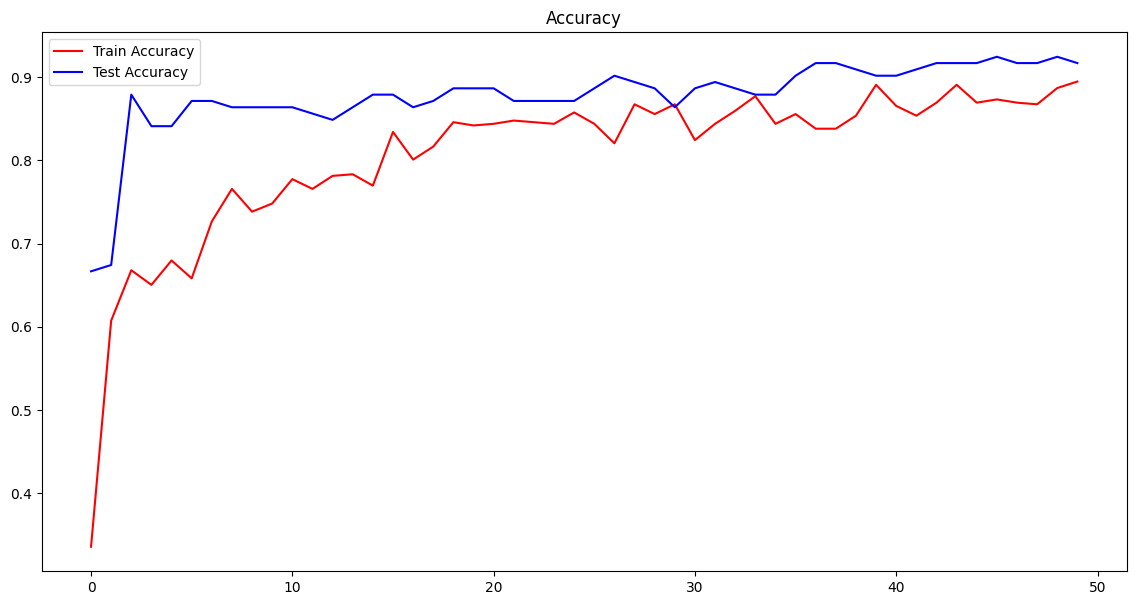

In [102]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

epochs = range(len(acc))
plt.figure(figsize = (14, 7))
plt.title('Accuracy')
plt.plot(epochs, acc, 'r', label = 'Train Accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Test Accuracy')
plt.legend(loc = 'upper left')

plt.show()

In [103]:
print(InceptionV3model.evaluate(testset))

      6/Unknown - 0s 41ms/step - loss: 5.6218e-05 - accuracy: 1.0000

132/132 [==============================] - 5s 34ms/step - loss: 0.3605 - accuracy: 0.9167
[0.3605257570743561, 0.9166666865348816]


In [104]:
#testds = list(testset)

#y_true = [y.numpy().argmax(1)[0] for _, y in testds]
y_pred3 = InceptionV3model.predict(tf.stack([x[0] for x, _ in testds])).argmax(1)

tf.math.confusion_matrix(labels=y_true, predictions=y_pred3)

5/5 [==============================] - 2s 77ms/step


<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[40,  4],
       [ 7, 81]], dtype=int32)>

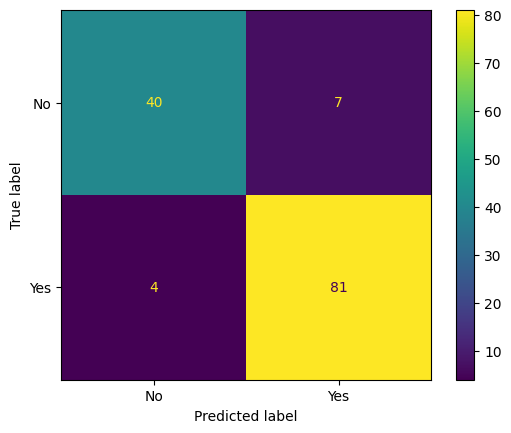

In [105]:
ConfusionMatrixDisplay(confusion_matrix(y_pred3, y_true), display_labels = ['No', 'Yes'], ).plot()
plt.show()

In [106]:
print(classification_report(y_pred3, y_true))

              precision    recall  f1-score   support

           0       0.91      0.85      0.88        47
           1       0.92      0.95      0.94        85

    accuracy                           0.92       132
   macro avg       0.91      0.90      0.91       132
weighted avg       0.92      0.92      0.92       132



### Xception

In [108]:
xception_model = tf.keras.applications.xception.Xception(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

for layer in xception_model.layers:
    layer.trainable = False

input = tf.keras.layers.Input(shape=(224, 224, 3))

fusion = tf.keras.layers.Concatenate()([
     tf.keras.layers.GlobalAveragePooling2D()(xception_model(input))
])
x = tf.keras.layers.Flatten()(xception_model(input))
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)

output = tf.keras.layers.Dense(2, activation="softmax")(x)

Xceptionmodel = tf.keras.models.Model(inputs=input, outputs=output)

Xceptionmodel.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [111]:
hist = Xceptionmodel.fit(trainset, validation_data=testset, epochs = 5)

Epoch 1/5


      6/Unknown - 11s 1s/step - loss: 0.3251 - accuracy: 0.8594

6/6 [==============================] - 13s 2s/step - loss: 0.3251 - accuracy: 0.8594 - val_loss: 0.3448 - val_accuracy: 0.9318
Epoch 2/5


6/6 [==============================] - ETA: 0s - loss: 0.2675 - accuracy: 0.9004

6/6 [==============================] - 13s 2s/step - loss: 0.2675 - accuracy: 0.9004 - val_loss: 0.4937 - val_accuracy: 0.8939
Epoch 3/5


6/6 [==============================] - ETA: 0s - loss: 0.4278 - accuracy: 0.8398

6/6 [==============================] - 11s 2s/step - loss: 0.4278 - accuracy: 0.8398 - val_loss: 0.3476 - val_accuracy: 0.8485
Epoch 4/5


6/6 [==============================] - ETA: 0s - loss: 0.2892 - accuracy: 0.8555

6/6 [==============================] - 11s 2s/step - loss: 0.2892 - accuracy: 0.8555 - val_loss: 0.4024 - val_accuracy: 0.9318
Epoch 5/5


6/6 [==============================] - ETA: 0s - loss: 0.3384 - accuracy: 0.8438

6/6 [==============================] - 11s 2s/step - loss: 0.3384 - accuracy: 0.8438 - val_loss: 0.4020 - val_accuracy: 0.9091


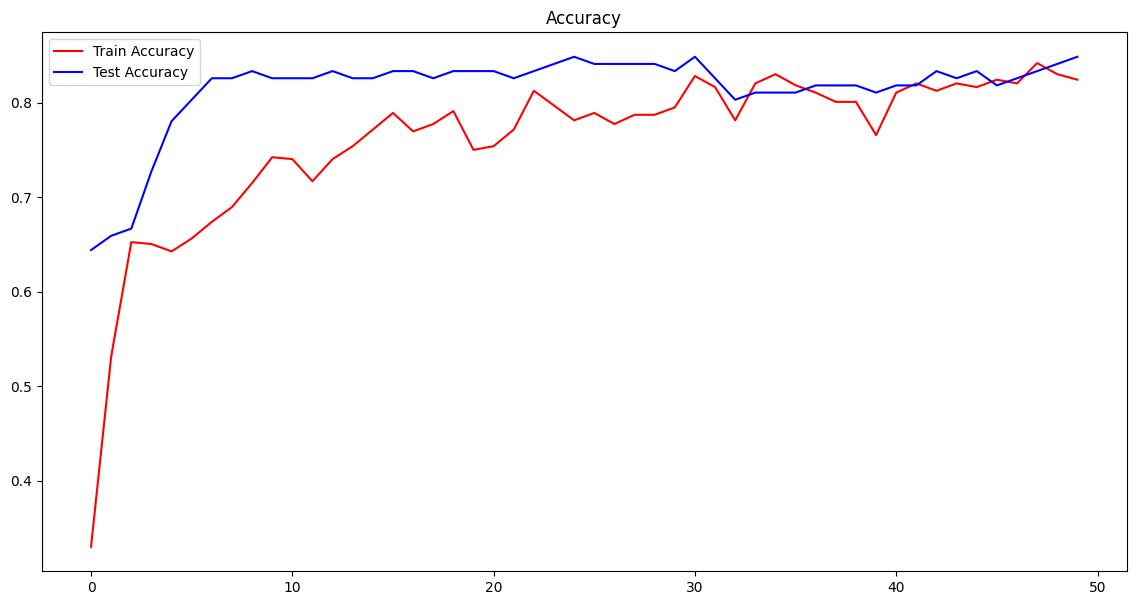

In [52]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

epochs = range(len(acc))
plt.figure(figsize = (14, 7))
plt.title('Accuracy')
plt.plot(epochs, acc, 'r', label = 'Train Accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Test Accuracy')
plt.legend(loc = 'upper left')

plt.show()

In [112]:
print(Xceptionmodel.evaluate(testset))

     10/Unknown - 0s 20ms/step - loss: 0.2209 - accuracy: 1.0000

132/132 [==============================] - 3s 20ms/step - loss: 0.4020 - accuracy: 0.9091
[0.4019636809825897, 0.9090909361839294]


In [113]:
#testds = list(testset)

#y_true = [y.numpy().argmax(1)[0] for _, y in testds]
y_pred4 = Xceptionmodel.predict(tf.stack([x[0] for x, _ in testds])).argmax(1)

tf.math.confusion_matrix(labels=y_true, predictions=y_pred4)

5/5 [==============================] - 2s 144ms/step


<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[39,  5],
       [ 7, 81]], dtype=int32)>

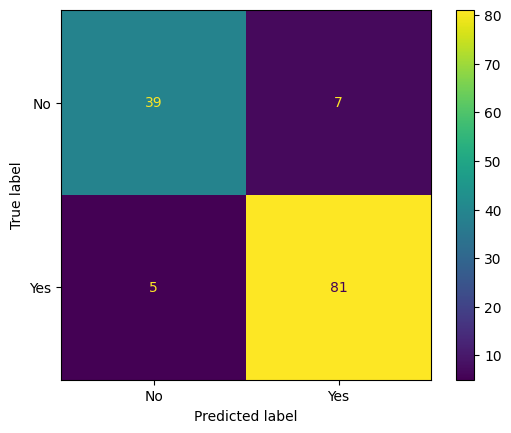

In [114]:
ConfusionMatrixDisplay(confusion_matrix(y_pred4, y_true), display_labels = ['No', 'Yes'], ).plot()
plt.show()

In [115]:
print(classification_report(y_pred4, y_true))

              precision    recall  f1-score   support

           0       0.89      0.85      0.87        46
           1       0.92      0.94      0.93        86

    accuracy                           0.91       132
   macro avg       0.90      0.89      0.90       132
weighted avg       0.91      0.91      0.91       132



### ensemble model

Majority vote technique:

In [116]:
y_pred = np.array([y_pred1, y_pred2, y_pred3, y_pred4])
y_pred = np.array([np.argmax(np.bincount(y_pred[:, i])) for i in range(len(testds))])

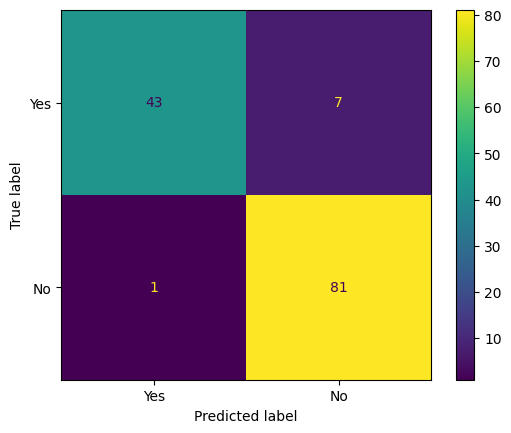

In [117]:
ConfusionMatrixDisplay(confusion_matrix(y_pred, y_true), display_labels = ['Yes', 'No'], ).plot()
plt.show()

In [118]:
print(classification_report(y_pred, y_true))

              precision    recall  f1-score   support

           0       0.98      0.86      0.91        50
           1       0.92      0.99      0.95        82

    accuracy                           0.94       132
   macro avg       0.95      0.92      0.93       132
weighted avg       0.94      0.94      0.94       132



In [119]:
from sklearn.metrics import accuracy_score
accuracy_score(y_pred, y_true)

0.9393939393939394